<a href="https://colab.research.google.com/github/Ecruzesp/Thesis/blob/main/CNN_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import glob
import cv2 as cv
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Capture images and labels into arrays.
#Start by creating empty lists.
images = []
labels = []
for directory_path in glob.glob("/content/drive/MyDrive/Thesis/Images/Kaggle/256/*"):
    label = directory_path.split("/")[-1]    
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        images.append(img)
        labels.append(label)
        
images = np.array(images)
labels = np.array(labels)

In [ ]:
images.shape

(1632, 256, 256, 3)

In [ ]:
#Capture images and labels into arrays.
#Start by creating empty lists.
images_validation = []
labels_validation = []
for directory_path in glob.glob("/content/drive/MyDrive/Thesis/Images/Base_Local/256/*"):
    label = directory_path.split("/")[-1]    
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        images_validation.append(img)
        labels_validation.append(label)
        
images_validation = np.array(images_validation)
labels_validation = np.array(labels_validation)

In [ ]:
images_validation.shape

(45, 256, 256, 3)

In [ ]:
# Encode labels from text (folder names) to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
le.fit(labels_validation)
labels = le.transform(labels)
labels_validation = le.transform(labels_validation)

In [ ]:
# test_size: what proportion of original data is used for test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = 1)

In [ ]:
#Normalize pixel values to between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

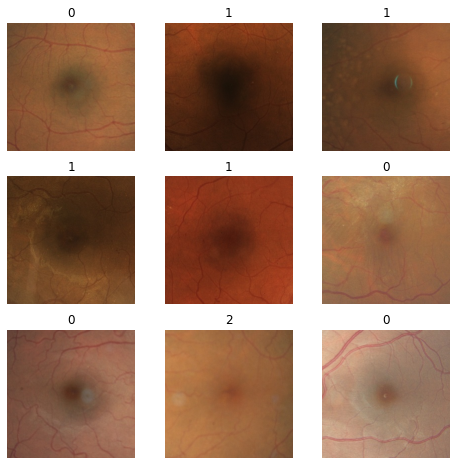

In [ ]:
from random import seed
from random import random
seed(3)
# Plot the first 10 images
plt.figure(figsize=(8, 8))
for i in range(9):
    j = int(random()*images.shape[0])
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[j])
    plt.title(labels[j])
    plt.axis("off")

In [ ]:
first_image = X_train[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

27 229


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(256,
                                  256,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
from tensorflow.keras.models import Sequential
CNN_model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same',activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='softmax')
])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
# Create Tensorflow checkpoint object which monitors the validation accuracy

#checkpoint_best_path = 'model_checkpoints_best/checkpoint'
#checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
#                                 save_weights_only=True,
#                                  save_freq='epoch',
#                                  monitor='val_sparse_categorical_accuracy',
#                                  save_best_only=True,
#                                  verbose=1
#                                 )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.001,
    cooldown=0,
    min_lr=0
)

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=15,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
CNN_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)     

In [ ]:
import time

epochs = 300
CNN_model_train_start = time.time()
CNN_model_history = CNN_model.fit(x=X_train,y=y_train, epochs=epochs, validation_data=(X_test, y_test),callbacks=[reduce_lr])
CNN_model_train_end = time.time()
CNN_model_train_time = CNN_model_train_end - CNN_model_train_start

Epoch 1/300
36/36 [==============================] - 7s 91ms/step - loss: 2.7302 - sparse_categorical_accuracy: 0.3415 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.3347 - lr: 0.0010
Epoch 2/300
36/36 [==============================] - 2s 66ms/step - loss: 1.0927 - sparse_categorical_accuracy: 0.3713 - val_loss: 1.0986 - val_sparse_categorical_accuracy: 0.3347 - lr: 0.0010
Epoch 3/300
36/36 [==============================] - 2s 68ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.3862 - val_loss: 1.0987 - val_sparse_categorical_accuracy: 0.3347 - lr: 0.0010
Epoch 4/300
36/36 [==============================] - 2s 67ms/step - loss: 1.0888 - sparse_categorical_accuracy: 0.3792 - val_loss: 1.0988 - val_sparse_categorical_accuracy: 0.3347 - lr: 0.0010
Epoch 5/300
36/36 [==============================] - 2s 67ms/step - loss: 1.0844 - sparse_categorical_accuracy: 0.3914 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.3633 - lr: 0.0010
Epoch 6/300
36/36 [================

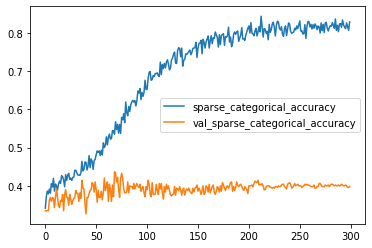

In [ ]:
# Plot training and testing curves
import pandas as pd

CNN_model_df = pd.DataFrame(CNN_model_history.history)
CNN_model_df.plot(y=['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

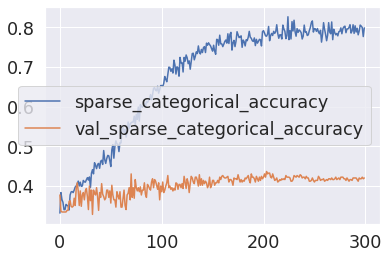

In [ ]:
# Plot training and testing curves

import pandas as pd

CNN_model_df = pd.DataFrame(CNN_model_history.history)
CNN_model_df.plot(y=['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'])

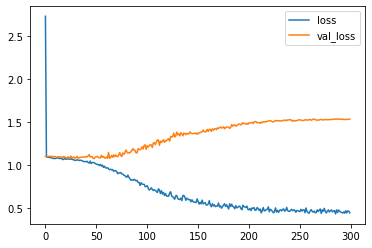

In [ ]:
CNN_model_df.plot(y=['loss', 'val_loss'])

In [ ]:
CNN_train_prediction_start = time.time()
CNN_prediction_train = CNN_model.predict(X_train)
CNN_train_prediction_end = time.time()
CNN_train_prediction_time = CNN_train_prediction_end - CNN_train_prediction_start

36/36 [==============================] - 1s 15ms/step


In [ ]:
CNN_test_prediction_start = time.time()
CNN_prediction_test = CNN_model.predict(X_test)
CNN_test_prediction_end = time.time()
CNN_test_prediction_time = CNN_test_prediction_end - CNN_test_prediction_start

16/16 [==============================] - 0s 12ms/step


In [ ]:
CNN_validation_prediction_start = time.time()
CNN_prediction_validation = CNN_model.predict(images_validation/255.)
CNN_validation_prediction_end = time.time()
CNN_validation_prediction_time = CNN_validation_prediction_end - CNN_validation_prediction_start

2/2 [==============================] - 0s 194ms/step


In [ ]:
CNN_train_prediction = np.zeros(CNN_prediction_train.shape[0])
for i in range(CNN_prediction_train.shape[0]):
    CNN_train_prediction[i] = np.argmax(CNN_prediction_train[i])

In [ ]:
CNN_test_prediction = np.zeros(CNN_prediction_test.shape[0])
for i in range(CNN_prediction_test.shape[0]):
    CNN_test_prediction[i] = np.argmax(CNN_prediction_test[i])

In [ ]:
CNN_validation_prediction = np.zeros(CNN_prediction_validation.shape[0])
for i in range(CNN_prediction_validation.shape[0]):
    CNN_validation_prediction[i] = np.argmax(CNN_prediction_validation[i])

              precision    recall  f1-score   support

           0     0.7862    0.9217    0.8486       383
           1     0.8533    0.8443    0.8488       379
           2     0.9780    0.8184    0.8911       380

    accuracy                         0.8616      1142
   macro avg     0.8725    0.8615    0.8628      1142
weighted avg     0.8723    0.8616    0.8628      1142



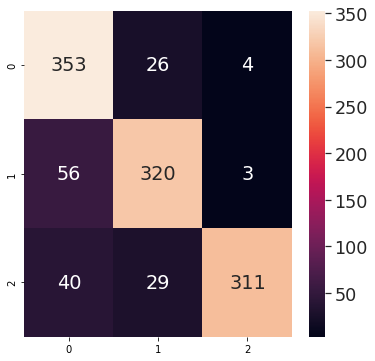

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
print(classification_report(y_train,CNN_train_prediction, digits=4))
cm_train = confusion_matrix(y_train, CNN_train_prediction)


fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_train, annot=True, ax=ax, fmt='g')

              precision    recall  f1-score   support

           0     0.3602    0.4720    0.4086       161
           1     0.3312    0.3212    0.3262       165
           2     0.5546    0.4024    0.4664       164

    accuracy                         0.3980       490
   macro avg     0.4154    0.3986    0.4004       490
weighted avg     0.4155    0.3980    0.4002       490



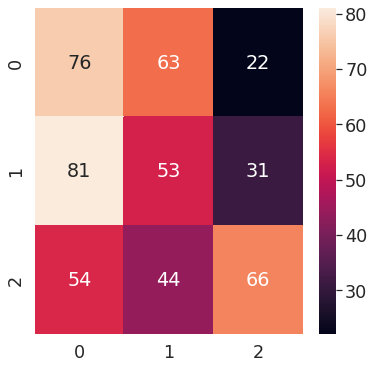

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
print(classification_report(y_test, CNN_test_prediction, digits=4))
cm_test = confusion_matrix(y_test, CNN_test_prediction)


fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_test, annot=True, ax=ax, fmt='g')

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        15
           1     0.3333    1.0000    0.5000        15
           2     0.0000    0.0000    0.0000        15

    accuracy                         0.3333        45
   macro avg     0.1111    0.3333    0.1667        45
weighted avg     0.1111    0.3333    0.1667        45



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


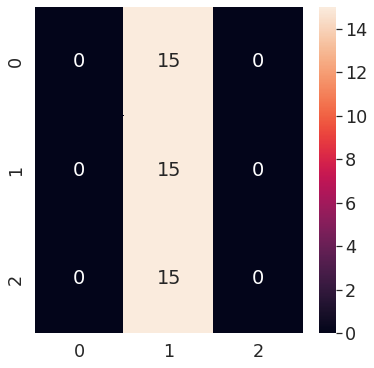

In [ ]:
print(classification_report(labels_validation,CNN_validation_prediction, digits=4))
cm_validation = confusion_matrix(labels_validation, CNN_validation_prediction)


fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm_validation, annot=True, ax=ax, fmt='g')

In [ ]:
def metrics_report(cm):
    
    Total = sum(sum(cm))
    
    Support_0 = sum(cm[0,:])
    Support_1 = sum(cm[1,:])
    Support_2 = sum(cm[2,:])
    
    TP_0 = cm[0,0]
    TP_1 = cm[1,1]
    TP_2 = cm[2,2]

    TN_0 = TP_1 + TP_2
    TN_1 = TP_0 + TP_2
    TN_2 = TP_0 + TP_1

    FP_0 = cm[1,0] + cm[2,0]
    FP_1 = cm[0,1] + cm[2,1]
    FP_2 = cm[0,2] + cm[1,2]

    FN_0 = cm[0,1] + cm[0,2]
    FN_1 = cm[1,0] + cm[1,2] 
    FN_2 = cm[2,0] + cm[2,1]
    
    Accuracy_0 = (TP_0 + TN_0) / (Total)
    Accuracy_1 = (TP_1 + TN_1) / (Total)
    Accuracy_2 = (TP_2 + TN_2) / (Total)
    Accuracy_Avg = (Accuracy_0 + Accuracy_1 + Accuracy_2) / 3
    
    Sensitivity_0 = TP_0 / (TP_0 + FN_0)
    Sensitivity_1 = TP_1 / (TP_1 + FN_1)
    Sensitivity_2 = TP_2 / (TP_2 + FN_2)
    Sensitivity_Avg = (Sensitivity_0 + Sensitivity_1 + Sensitivity_2) / 3
    
    Specificity_0 = TN_0 / (TN_0 + FP_0)
    Specificity_1 = TN_1 / (TN_1 + FP_1)
    Specificity_2 = TN_2 / (TN_2 + FP_2)
    Specificity_Avg = (Specificity_0 + Specificity_1 + Specificity_2) / 3

    False_negative_rate_0 = FN_0 / (FN_0 + TP_0)
    False_negative_rate_1 = FN_1 / (FN_1 + TP_1)
    False_negative_rate_2 = FN_2 / (FN_2 + TP_2)
    False_negative_rate_Avg = (False_negative_rate_0 + False_negative_rate_1 + False_negative_rate_2) / 3

    return(Accuracy_Avg,Sensitivity_0,Specificity_0,False_negative_rate_0)

In [ ]:
columns = ['training time','test prediction time','validation prediction time','train accuracy', 'test accuracy','validation accuracy',
      'test sensitivity','validation sensitivity','test specificity','validation specificity',
      'test false negative rate','validation false negative rate']

index = ['CNN']

CNN_metrics_df = pd.DataFrame(index=index , columns=columns)
       
cm_train_CNN = confusion_matrix(y_train, CNN_train_prediction)

metrics_train_CNN = metrics_report(cm_train_CNN)
train_accuracy = metrics_train_CNN[0]
train_sensitivity = metrics_train_CNN[1]
train_specificity = metrics_train_CNN[2]
train_false_negative_rate = metrics_train_CNN[3]


cm_test_CNN = confusion_matrix(y_test, CNN_test_prediction)

metrics_test_CNN = metrics_report(cm_test_CNN)
test_accuracy = metrics_test_CNN[0]
test_sensitivity = metrics_test_CNN[1]
test_specificity = metrics_test_CNN[2]
test_false_negative_rate = metrics_test_CNN[3]


cm_validation_CNN = confusion_matrix(labels_validation, CNN_validation_prediction)

metrics_validation_CNN = metrics_report(cm_validation_CNN)
validation_accuracy = metrics_validation_CNN[0]
validation_sensitivity = metrics_validation_CNN[1]
validation_specificity = metrics_validation_CNN[2]
validation_false_negative_rate = metrics_validation_CNN[3]

CNN_metrics_df.iloc[0,0] = CNN_model_train_time
CNN_metrics_df.iloc[0,1] = CNN_test_prediction_time
CNN_metrics_df.iloc[0,2] = CNN_validation_prediction_time
CNN_metrics_df.iloc[0,3] = train_accuracy
CNN_metrics_df.iloc[0,4] = test_accuracy
CNN_metrics_df.iloc[0,5] = validation_accuracy
CNN_metrics_df.iloc[0,6] = test_sensitivity
CNN_metrics_df.iloc[0,7] = validation_sensitivity
CNN_metrics_df.iloc[0,8] = test_specificity
CNN_metrics_df.iloc[0,9] = validation_specificity
CNN_metrics_df.iloc[0,10] = test_false_negative_rate
CNN_metrics_df.iloc[0,11] = validation_false_negative_rate

CNN_metrics_df

,training time,test prediction time,validation prediction time,train accuracy,test accuracy,validation accuracy,test sensitivity,validation sensitivity,test specificity,validation specificity,test false negative rate,validation false negative rate
CNN,803.14842,0.322809,0.468928,0.861646,0.397959,0.333333,0.47205,0.0,0.468504,1.0,0.52795,1.0
